In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
import gzip

In [2]:
df = pd.read_csv('../data/dataset.csv')

In [3]:
df.head()

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,predicted_category,sentiment,appVersion
0,326d4bdd-8fc6-4d64-b3bf-ce393fb2ae9b,woww,5,0,NaN,2022-08-16 05:55:38,NaN,NaN,USER_EXPERIENCE,NEUTRAL,NaN
1,4bbf741b-2f69-43cd-bb76-f9b5f84c83b5,let me know more details about this,3,0,4.5.1143533,2022-08-16 04:44:45,NaN,NaN,CONTENT,NEUTRAL,NaN
2,3cb1136d-e7c6-4999-aa84-fdc7bcdccf56,i've been using this for a while and there's a...,2,0,4.5.1143533,2022-08-16 04:05:27,NaN,NaN,INTERFACE,NEGATIVE,NaN
3,d6f80f05-a6e8-44f3-a380-7c59ed3d208b,good,2,0,4.5.1143533,2022-08-16 00:22:33,NaN,NaN,USER_EXPERIENCE,POSITIVE,NaN
4,eecb277c-c658-4b2d-86c9-77d3a7022cac,mjkobe,5,0,4.5.1143533,2022-08-15 20:08:25,NaN,NaN,USER_EXPERIENCE,NEUTRAL,NaN


In [4]:
columns_to_remove = ['reviewId','score','thumbsUpCount','reviewCreatedVersion','at','replyContent','repliedAt', 'predicted_category','appVersion']

df.drop(columns=columns_to_remove, inplace=True)
df = df.rename(columns={'content': 'review'})

In [5]:
df.head()

,review,sentiment
0,woww,NEUTRAL
1,let me know more details about this,NEUTRAL
2,i've been using this for a while and there's a...,NEGATIVE
3,good,POSITIVE
4,mjkobe,NEUTRAL


In [6]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     53043 non-null  object
 1   sentiment  53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


In [8]:
df.dtypes

review       object
sentiment    object
dtype: object

In [9]:
df['sentiment'].value_counts()

sentiment
POSITIVE    39982
NEUTRAL      7198
NEGATIVE     5863
Name: count, dtype: int64

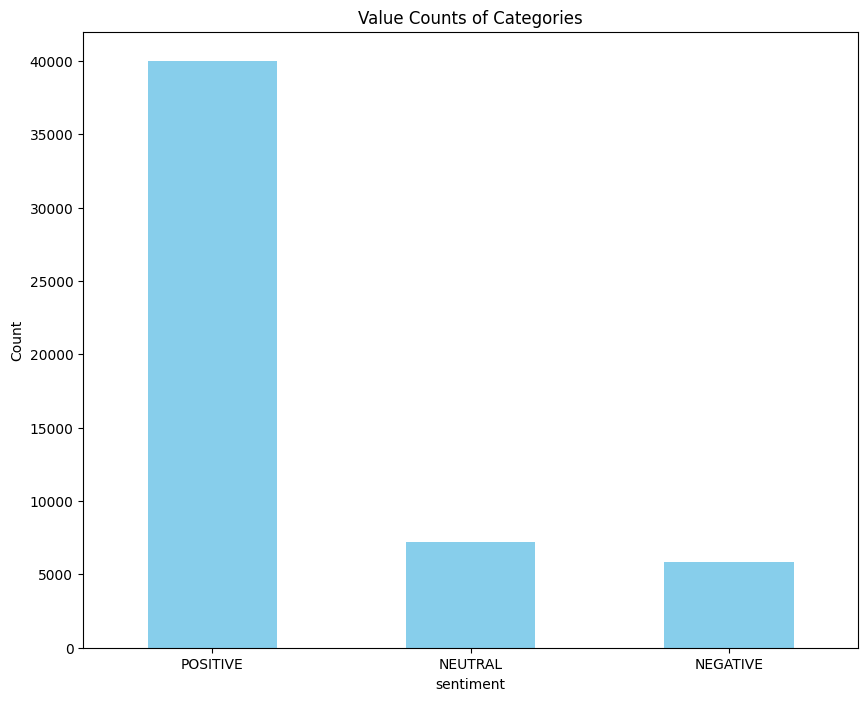

In [10]:
value_counts = df['sentiment'].value_counts()

# Plot the value counts
plt.figure(figsize=(10, 8))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Value Counts of Categories')
plt.xlabel('sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### We will not handle class imabalance as it leads to information loss

### Text cleaning

In [13]:
def remove_characters(text):
    return re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]', '', text)
df['review'] = df['review'].apply(remove_characters)

### Removing stop words 

In [14]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

df['review'] = df['review'].apply(remove_stopwords)

In [15]:
df

,review,sentiment
0,woww,NEUTRAL
1,let know details,NEUTRAL
2,ive using theres basic bug still fixed scrolli...,NEGATIVE
3,good,POSITIVE
4,mjkobe,NEUTRAL
...,...,...
53038,nice,POSITIVE
53039,mahalo nui tanks ah,NEUTRAL
53040,useful app,POSITIVE
53041,love thank team medium god bless amen,POSITIVE


In [16]:
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [17]:
# 0 is negative; 1 is neutral; 2 is positive 
df.head()

,review,sentiment
0,woww,1
1,let know details,1
2,ive using theres basic bug still fixed scrolli...,0
3,good,2
4,mjkobe,1


In [18]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['review'])
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
dt_model = DecisionTreeClassifier(class_weight=None, min_samples_leaf=1,min_samples_split=2,random_state=123)

dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.75      0.50      0.60      1749
           1       0.49      0.84      0.62      1806
           2       0.78      0.44      0.57      1722

    accuracy                           0.60      5277
   macro avg       0.67      0.59      0.59      5277
weighted avg       0.67      0.60      0.59      5277



In [20]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

In [25]:
print("Macro F1 score is: ",f1_score(y_test, y_pred_rf, average= 'macro'))
print("Accuracy is: ",accuracy_score(y_test,y_pred_rf))
print("Confusion Matrix is as follows: \n",confusion_matrix(y_test,y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Macro F1 score is:  0.7562080465720017
Accuracy is:  0.8713630365110288
Confusion Matrix is as follows: 
 [[ 1075   170   502]
 [  146  1282   762]
 [  127   340 11509]]
              precision    recall  f1-score   support

           0       0.80      0.62      0.69      1747
           1       0.72      0.59      0.64      2190
           2       0.90      0.96      0.93     11976

    accuracy                           0.87     15913
   macro avg       0.80      0.72      0.76     15913
weighted avg       0.86      0.87      0.86     15913



In [27]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest model
rf = RandomForestClassifier()

# Perform GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, verbose=1)
rf_grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Best Score for Random Forest:", rf_grid_search.best_score_)

# Prediction with best Random Forest model
best_rf_model = rf_grid_search.best_estimator_
y_pred_rf_optimized = best_rf_model.predict(X_test)

print("Macro F1 score is: ",f1_score(y_test, y_pred_rf_optimized, average= 'macro'))
print("Accuracy is: ",accuracy_score(y_test,y_pred_rf_optimized))
print("Confusion Matrix is as follows: \n",confusion_matrix(y_test,y_pred_rf_optimized))
print(classification_report(y_test, y_pred_rf_optimized)) 

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score for Random Forest: 0.8670078167313314
Macro F1 score is:  0.7547586292681571
Accuracy is:  0.8712373531075221
Confusion Matrix is as follows: 
 [[ 1092   148   507]
 [  160  1235   795]
 [  127   312 11537]]
              precision    recall  f1-score   support

           0       0.79      0.63      0.70      1747
           1       0.73      0.56      0.64      2190
           2       0.90      0.96      0.93     11976

    accuracy                           0.87     15913
   macro avg       0.81      0.72      0.75     15913
weighted avg       0.86      0.87      0.86     15913



In [28]:
best_rf_model

RandomForestClassifier(min_samples_split=5)

In [25]:
new_data = ["VERY BAD!!"]
new_data_vectorized = vectorizer.transform(new_data)
predictions = best_rf_model.predict(new_data_vectorized)
predicted_sentiments = label_encoder.inverse_transform(predictions)

print(predicted_sentiments)

['NEGATIVE']


##### Fitting on X,train, y_train with best parameters

In [29]:
best_rf_model = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 100)
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5)

In [30]:
data = {"best_model": best_rf_model, "le": label_encoder, "vectorizer": vectorizer}
with gzip.open('optimized_model_steps.pkl.gz', 'wb') as file:
    pickle.dump(data, file)